# <center>Лабораторна робота 2</center>
<center><b>Дмитренко ФБ-04</b></center>


Lab 1: Базові алгоритми навчання без учителя та обробка текстових даних (Scikit-learn lib)

---

### Хід роботи

Використовуємо датасет з першої лаби US Election 2020 конкретніше таблицю president_county_candidate.csv [Kaggle](https://www.kaggle.com/datasets/unanimad/us-election-2020/data?select=president_county_candidate.csv)

# Попередня обробка

## Імпорти, читання, аналіз

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1) Завантажити дані, вивести назви колонок і розмір датасета

In [127]:
df = pd.read_csv("../lab1/president_county_candidate.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32177 entries, 0 to 32176
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   state        32177 non-null  object
 1   county       32177 non-null  object
 2   candidate    32177 non-null  object
 3   party        32177 non-null  object
 4   total_votes  32177 non-null  int64 
 5   won          32177 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 1.3+ MB


In [128]:
# Видалення колонки 'county'
df = df.drop(columns=['county'])

# Оставити тільки двох топ кандидатів, інших помітити як 'other'
top_candidates = df['candidate'].value_counts().nlargest(2).index
mask_candidate = df['candidate'].isin(top_candidates)
df.loc[~mask_candidate, 'candidate'] = 'other'

# Аналогічно для партій (party)
top_parties = df['party'].value_counts().nlargest(2).index
mask_party = df['party'].isin(top_parties)
df.loc[~mask_party, 'party'] = 'other'

# Групування даних по штату, кандидату та партії, підсумовування голосів
df = df.groupby(['state', 'candidate', 'party'])['total_votes'].sum().reset_index()

In [129]:
print("Назви колонок:", df.columns)
print("Розмір датасету:", df.shape)

Назви колонок: Index(['state', 'candidate', 'party', 'total_votes'], dtype='object')
Розмір датасету: (153, 4)


In [130]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype('category').cat.codes

### 2) Опрацювати пропуски (по можливості заповнити їх або видалити)

In [131]:
missing_values = df.isnull().sum()
print("Кількість пропусків у колонках:\n", missing_values)

Кількість пропусків у колонках:
 state          0
candidate      0
party          0
total_votes    0
dtype: int64


Як бачу у датасеті немає пропусків, але так як це вже 3й датасет, тому для не числових колонок заповню пропуски найпопулянрішмим значеннями, а для числових значень -- середніми (що не робив, проте хай буде)

In [132]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].mean(), inplace=True)

### 3) Візуалізувати дані

#### 3.1) Heatmap 

Так як у датасеті є не інтові значення, перетворю їх на int використовуючи .astype('category').cat.codes

In [133]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype('category').cat.codes

In [134]:
df.head()

state  candidate  party  total_votes
0      0          0      1      1441168
1      0          1      0       849648
2      0          2      2        32488
3      1          0      1       189892
4      1          1      0       153405

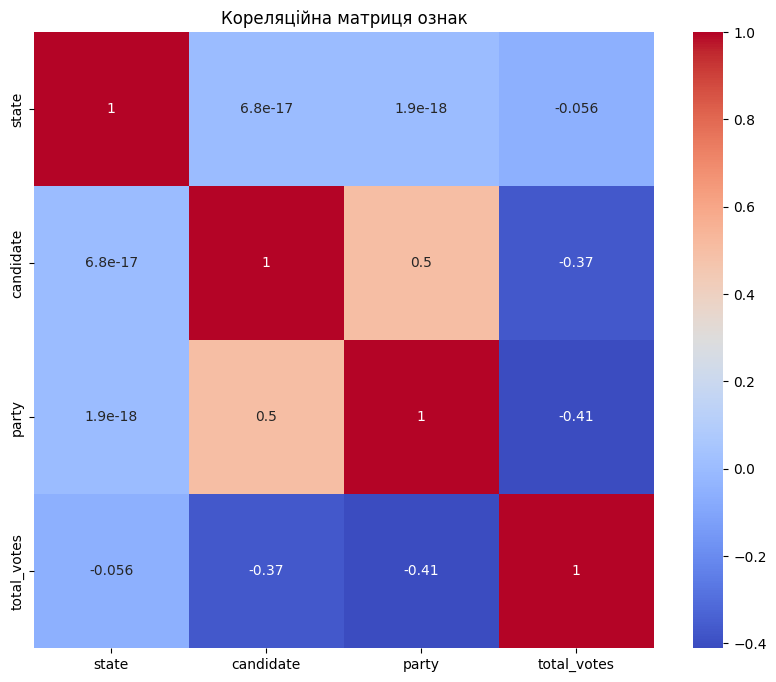

In [135]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Кореляційна матриця ознак')
plt.show()

#### 3.2) Гістограма 

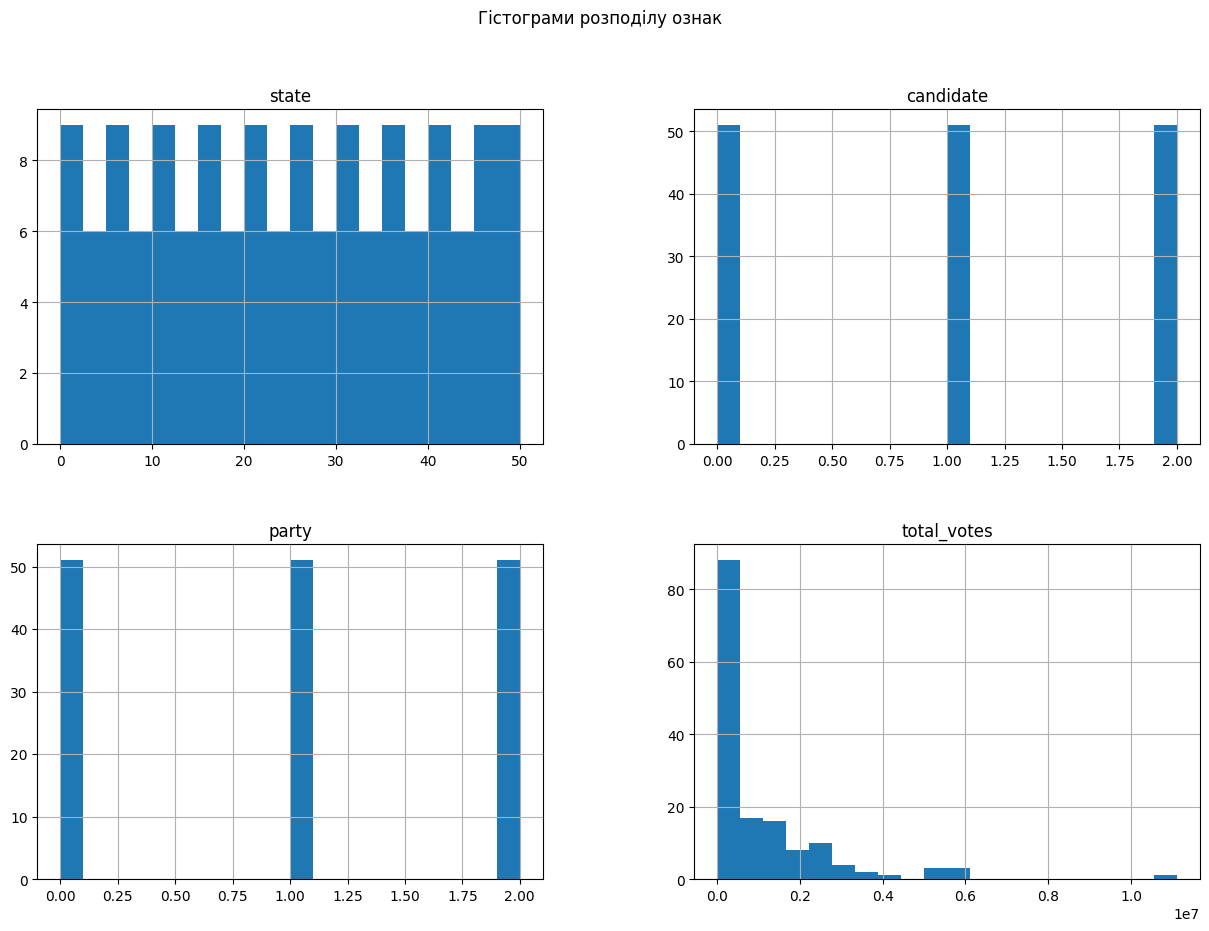

In [136]:
df.hist(figsize=(15, 10), bins=20)
plt.suptitle('Гістограми розподілу ознак')
plt.show()

#### 3.3) Boxplot 

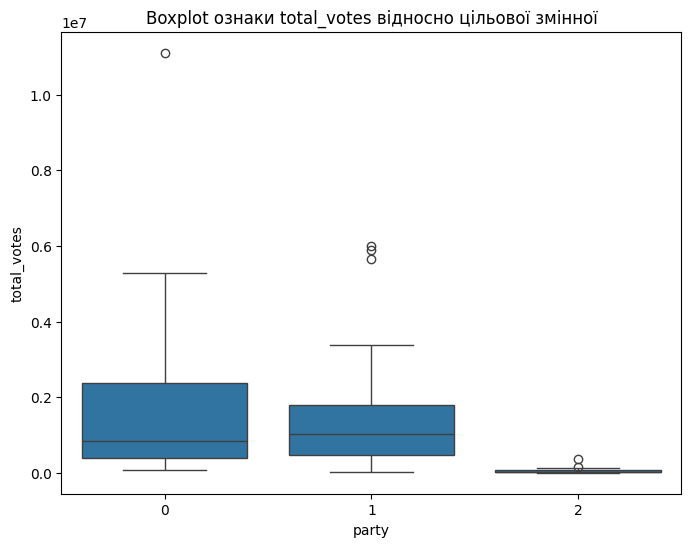

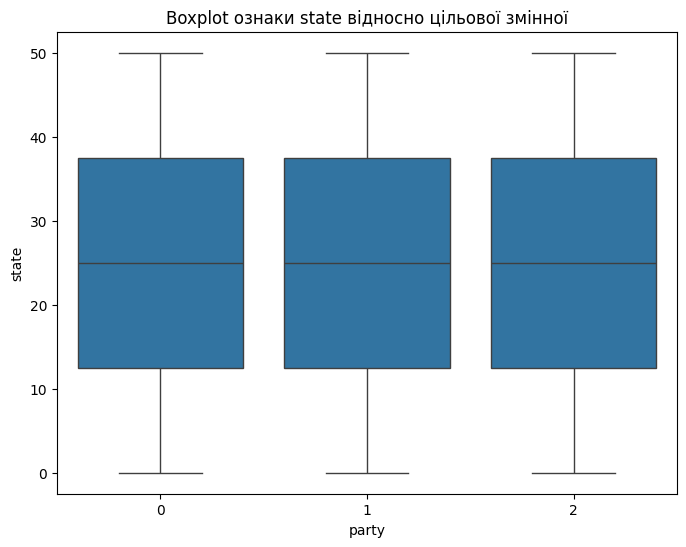

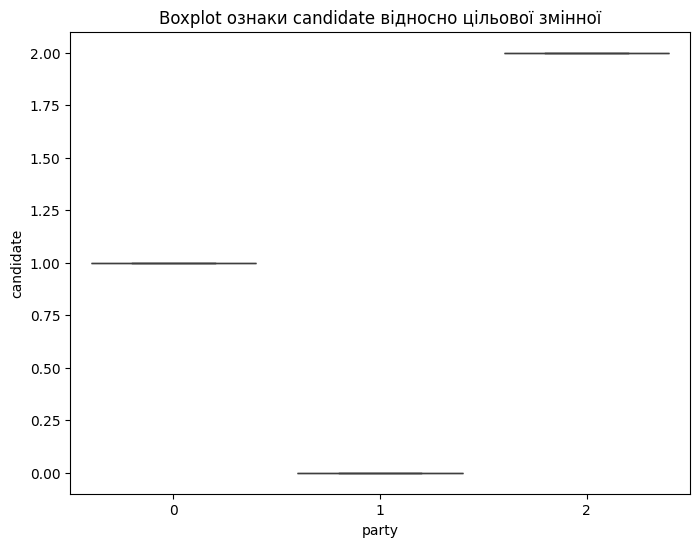

In [137]:
target = 'party'
features = set(df.columns)
features.remove(target)
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=target, y=feature, data=df)
    plt.title(f'Boxplot ознаки {feature} відносно цільової змінної')
    plt.show()


# Виконання роботи

### 1. Зниження розмірності і візуалізація даних

In [138]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [139]:
features = df.drop(columns=['party'])
votes = df['party']

In [140]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [141]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

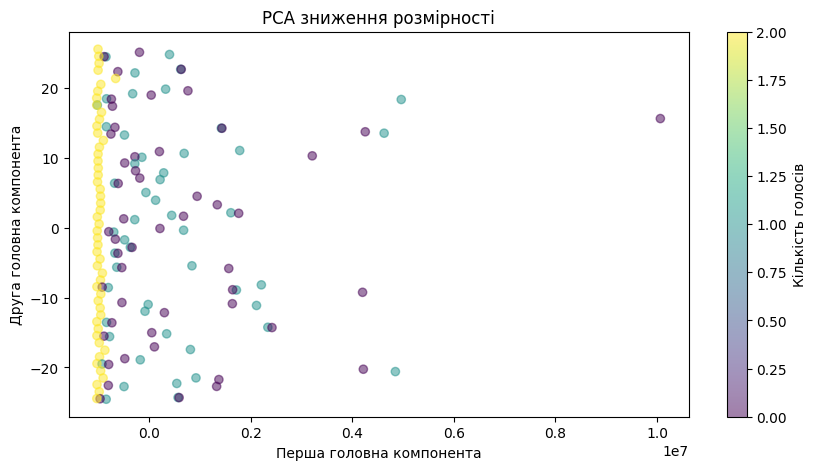

In [142]:
plt.figure(figsize=(10, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=votes, cmap='viridis', alpha=0.5)
plt.title("PCA зниження розмірності")
plt.xlabel("Перша головна компонента")
plt.ylabel("Друга головна компонента")
plt.colorbar(label='Кількість голосів')
plt.show()


In [143]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features_scaled)


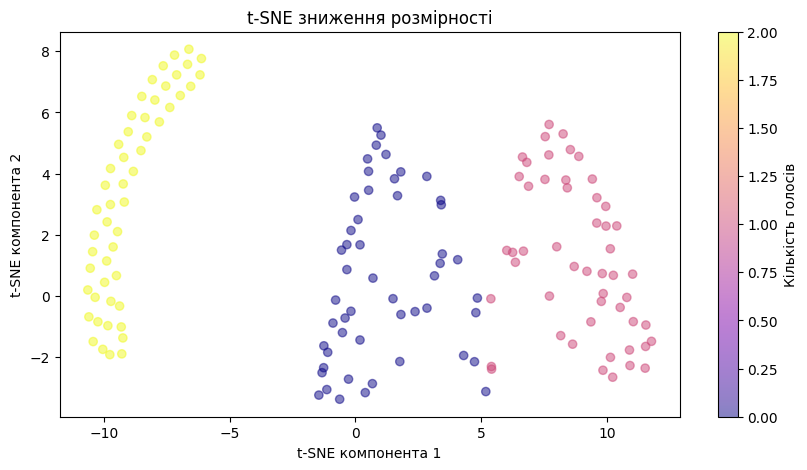

In [144]:
plt.figure(figsize=(10, 5))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=votes, cmap='plasma', alpha=0.5)
plt.title("t-SNE зниження розмірності")
plt.xlabel("t-SNE компонента 1")
plt.ylabel("t-SNE компонента 2")
plt.colorbar(label='Кількість голосів')
plt.show()


### 2: Кластерний аналіз із використанням K-Means для зображення

In [145]:
from sklearn.cluster import KMeans
from skimage import io

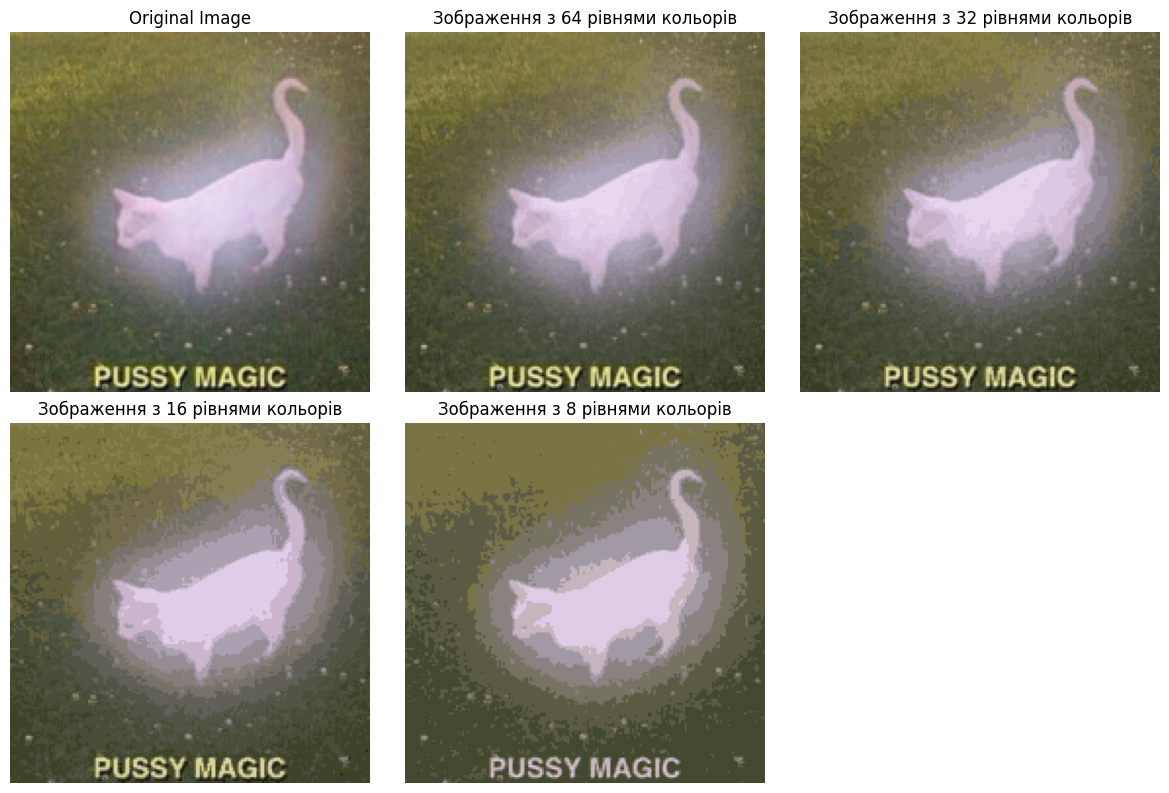

In [146]:
image = io.imread('kitty_magic.jpg')  # Заміни шлях на свій
image = image / 255.0  # Нормалізація значень пікселів до [0, 1]

plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

original_shape = image.shape
pixels = image.reshape(-1, 3)

# Виконання квантування для різних рівнів (64, 32, 16, 8)
for i, n_colors in enumerate([64, 32, 16, 8]):
    kmeans = KMeans(n_clusters=n_colors, n_init='auto', random_state=42)
    kmeans.fit(pixels)
    new_colors = kmeans.cluster_centers_[kmeans.labels_]
    quantized_image = new_colors.reshape(original_shape)

    # Візуалізація
    plt.subplot(2, 3, i+2)
    plt.imshow(quantized_image)
    plt.title(f"Зображення з {n_colors} рівнями кольорів")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 3: Обробка та класифікація текстових даних

In [147]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [148]:
data = pd.read_csv('tweet_emotions.csv')

In [149]:
# # Закомментив бо вже завантажено
# import nltk
# nltk.download('stopwords') 

from nltk.corpus import stopwords
import string

stop_words = set(stopwords.words('english'))

# Видалення стоп-слів та передобробка тексту
def preprocess_text(text):
    text = text.lower()  # Зниження регістру
    text = ''.join([char for char in text if char not in string.punctuation])  # Видалення пунктуації
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Видалення стоп-слів
    return text

data['content'] = data['content'].apply(preprocess_text)

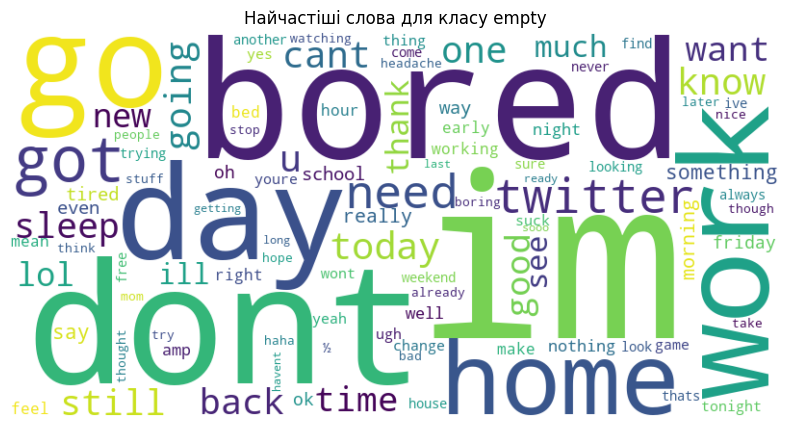

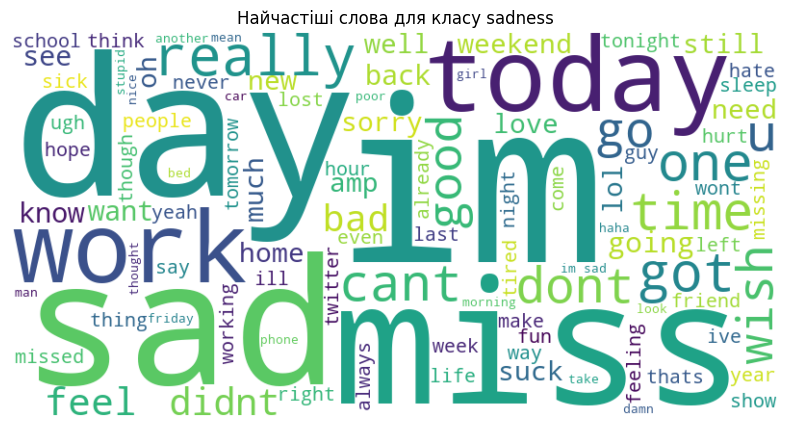

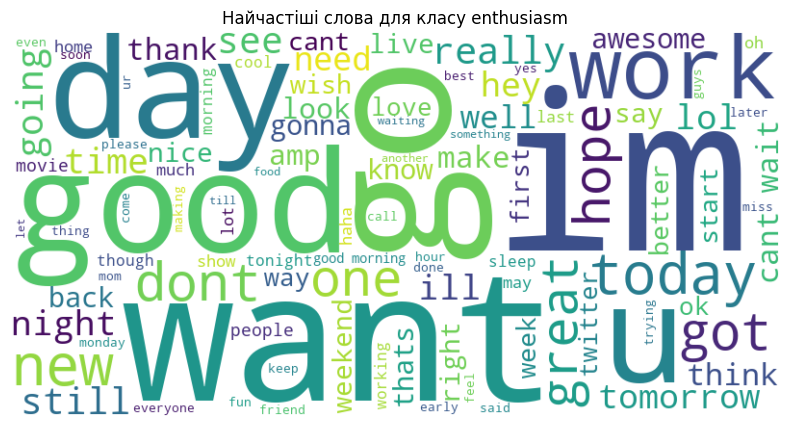

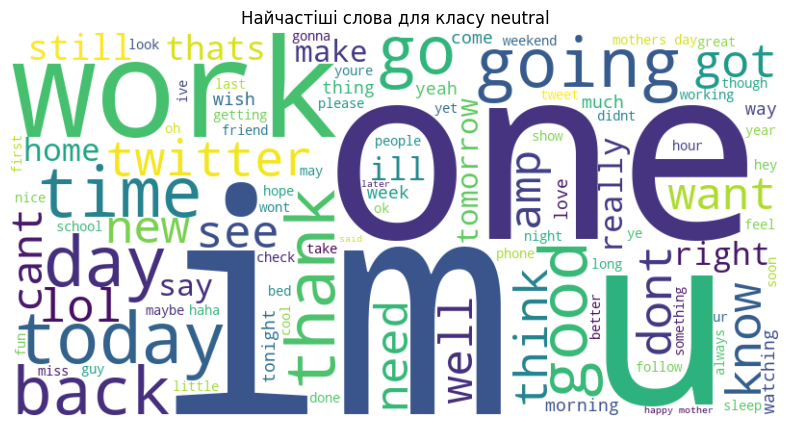

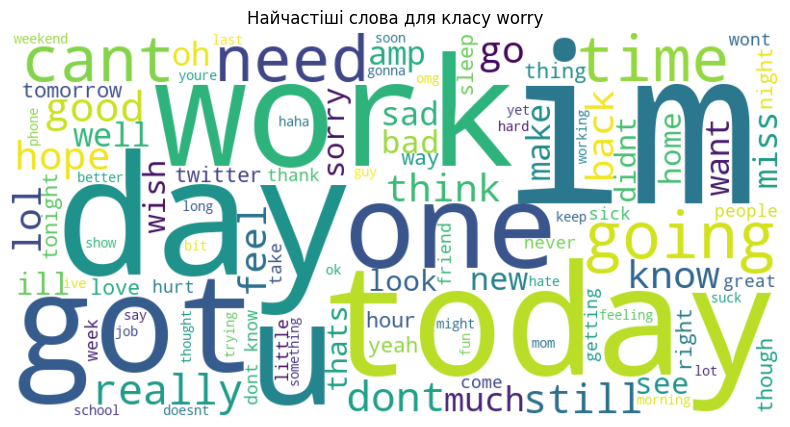

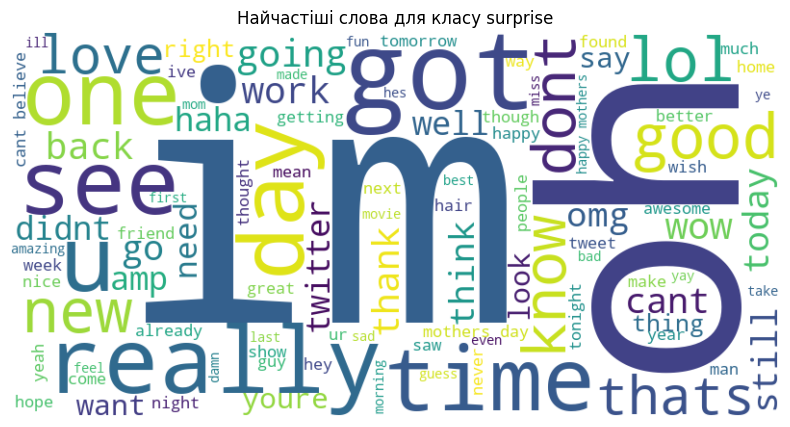

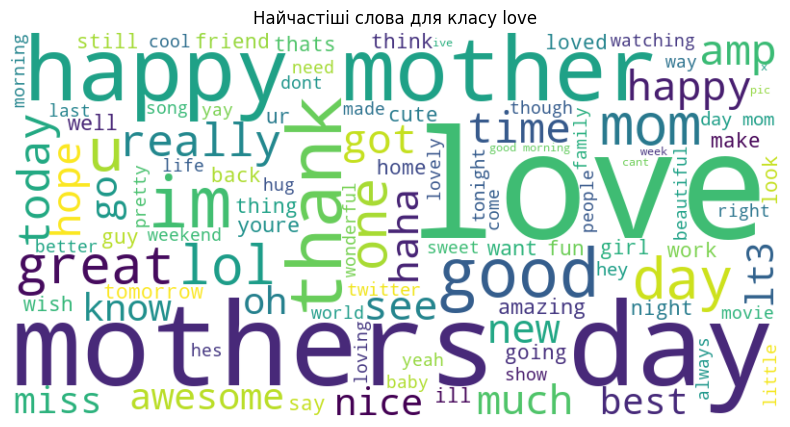

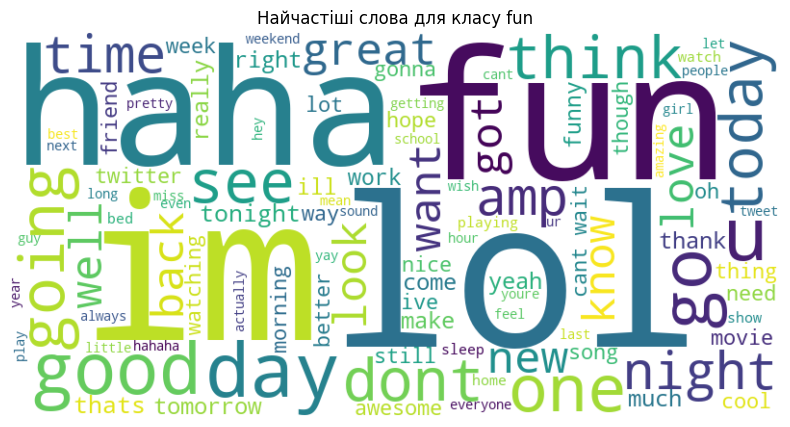

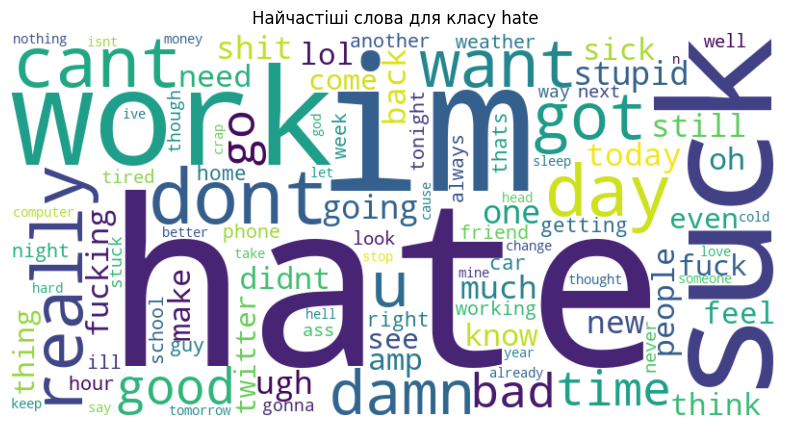

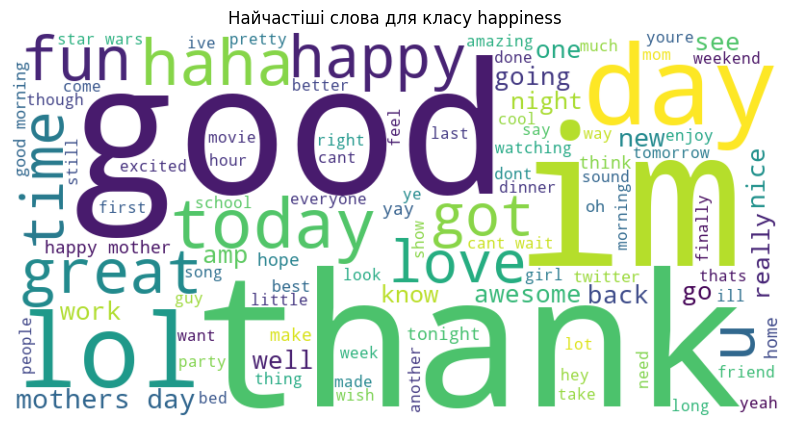

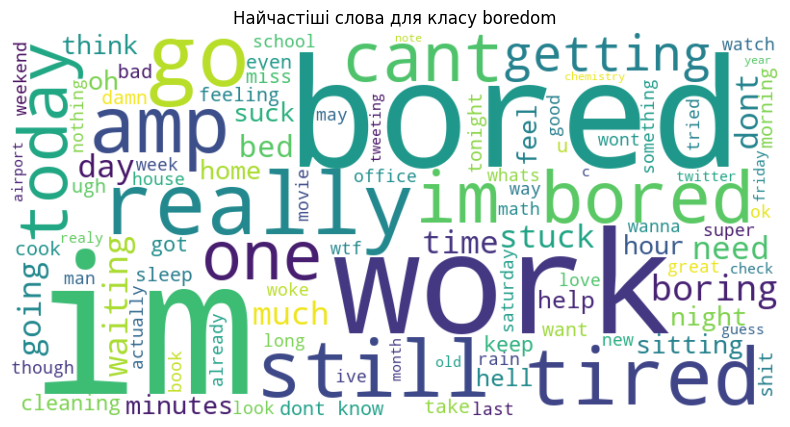

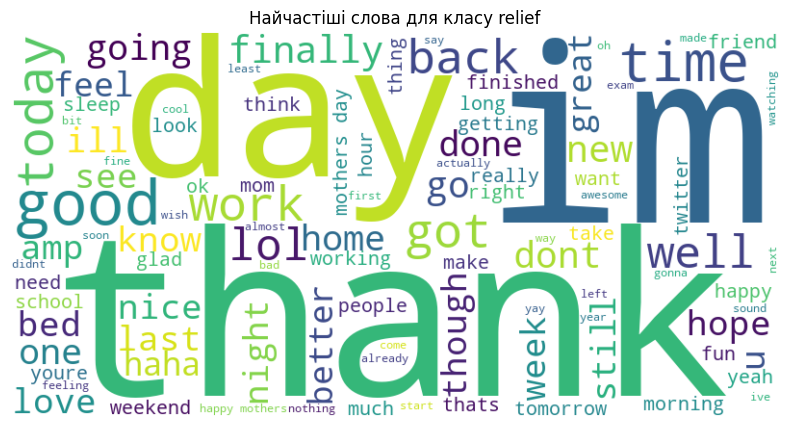

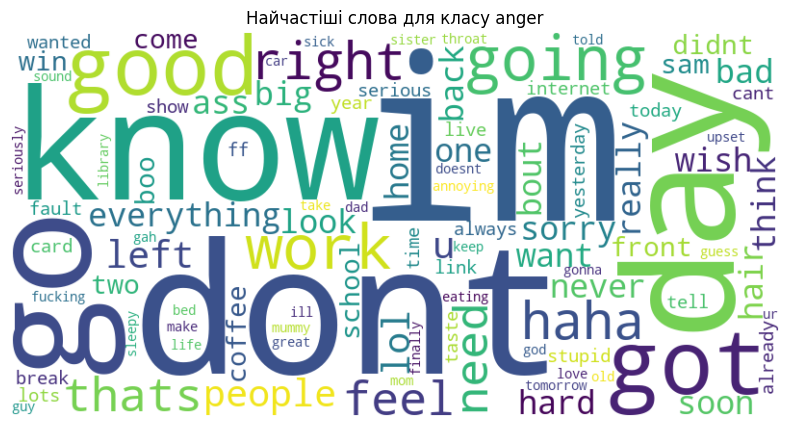

In [150]:
# Створення WordCloud для кожного класу
for sentiment in data['sentiment'].unique():
    text = ' '.join(data[data['sentiment'] == sentiment]['content'])
    wordcloud = WordCloud(background_color='white', width=800, height=400, max_words=100).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Найчастіші слова для класу {sentiment}")
    plt.axis('off')
    plt.show()

In [151]:
# Векторизація текстів
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['content'])
y = data['sentiment']

# Розділення на тренувальні і тестові дані
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Навчання класифікатора
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Прогнозування і оцінка якості
y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.290125


In [152]:
print(classification_report(y_test, y_pred, zero_division=0.0))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.00      0.00      0.00        31
       empty       0.00      0.00      0.00       162
  enthusiasm       0.00      0.00      0.00       163
         fun       0.00      0.00      0.00       338
   happiness       0.44      0.13      0.20      1028
        hate       0.00      0.00      0.00       268
        love       0.59      0.14      0.23       762
     neutral       0.31      0.45      0.36      1740
      relief       0.00      0.00      0.00       352
     sadness       0.29      0.01      0.01      1046
    surprise       0.00      0.00      0.00       425
       worry       0.26      0.78      0.39      1666

    accuracy                           0.29      8000
   macro avg       0.15      0.12      0.09      8000
weighted avg       0.27      0.29      0.21      8000

